# Load libraries

In [1]:
import os, torch, tqdm, logging, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

from unet.PyTorch import UNet, BESNet
from utils.dataset import PetDataset, MRDataset
from options.train_options import get_opt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Configuration setting

In [2]:
return_edge = True
image_height = 128
image_width = 128
train_rate = 1
batch_size = 8
num_epoch = 30
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 0.5 # same setting from paper
beta = 1 # same setting from paper

# Torch dataset and dataloaders

In [3]:
# Data directory configurations
base_dir = 'data/lgg-mri-segmentation/kaggle_3m'

# load dataset and dataloader
trans_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_height, image_width))
])
trans_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_height, image_width))
])
# dataset returns edges only for the BESNet
list_mr_files_train = [f for f in glob.glob(os.path.join(base_dir, '*', r'*[0-9].tif')) if '_CS_' not in f]
list_mr_files_test = glob.glob(os.path.join(base_dir, '*_CS_*', r'*[0-9].tif'))
dataset = MRDataset(list_mr_files_train, transform_image = trans_image, transform_mask = trans_mask, return_edge = return_edge)
dataset_test = MRDataset(list_mr_files_test, transform_image = trans_image, transform_mask = trans_mask, return_edge = return_edge)
# train/val/test split
train_size = int(len(dataset) * train_rate)
val_size = len(dataset) - train_size
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])
# make dataloader
dataloaders = {
    'train': DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 8),
    'val': DataLoader(dataset_val, batch_size = batch_size, shuffle = False, num_workers = 8),
    'test': DataLoader(dataset_test, batch_size = batch_size, shuffle = False, num_workers = 8)
}

# Load some example images to see the result

In [4]:
sample_image_index = [81, 203, 311, 131, 246]
sample_image_files = [list_mr_files_test[i].split('/')[-1].split('.')[0] for i in sample_image_index]
# paired mask and edge file
list_mask_file = [f[:-4] + '_mask.tif' for f in list_mr_files_test]
list_edge_file = [f[:-4] + '_edge.tif' for f in list_mr_files_test]
# load images
list_images = [Image.open(list_mr_files_test[idx]) for idx in sample_image_index]
list_images = [torch.unsqueeze(trans_image(image), dim = 0).to(device) for image in list_images]
list_images_reshaped = [Image.open(list_mr_files_test[idx]).resize((image_height, image_width)) for idx in sample_image_index]
list_edge = [Image.open(list_edge_file[idx]) for idx in sample_image_index]
list_mask = [Image.open(list_mask_file[idx]) for idx in sample_image_index]

In [5]:
def show_result_unet(net, img_torch, img_raw, target_mask, fname, return_output = True, show_result = False):
    mask = net(img_torch)
    mask = mask[0,0].detach().cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize = (15, 5))
    axes[0].imshow(img_raw); axes[0].set_axis_off()
    axes[1].imshow(target_mask); axes[1].set_axis_off()
    axes[2].imshow(mask); axes[2].set_axis_off()

    fig.suptitle(fname, fontsize = 30)
    fig.tight_layout()
    if show_result:
        plt.show()
    else:
        plt.close()
    if return_output:
        fig.canvas.draw()
        return Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

def show_result_besnet(net, img_torch, img_raw, target_mask, target_edge, fname, return_output = True, show_result = False):
    edge, mask = net(img_torch)
    edge = edge[0,0].detach().cpu().numpy()
    mask = mask[0,0].detach().cpu().numpy()
    fig, axes = plt.subplots(1, 5, figsize = (25, 5))
    axes[0].imshow(img_raw); axes[0].set_axis_off()
    axes[1].imshow(target_edge); axes[1].set_axis_off()
    axes[2].imshow(edge); axes[2].set_axis_off()
    axes[3].imshow(target_mask); axes[3].set_axis_off()
    axes[4].imshow(mask); axes[4].set_axis_off()
    fig.suptitle(fname, fontsize = 30)
    fig.tight_layout()
    if show_result:
        plt.show()
    else:
        plt.close()
    if return_output:
        fig.canvas.draw()
        return Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Train UNet

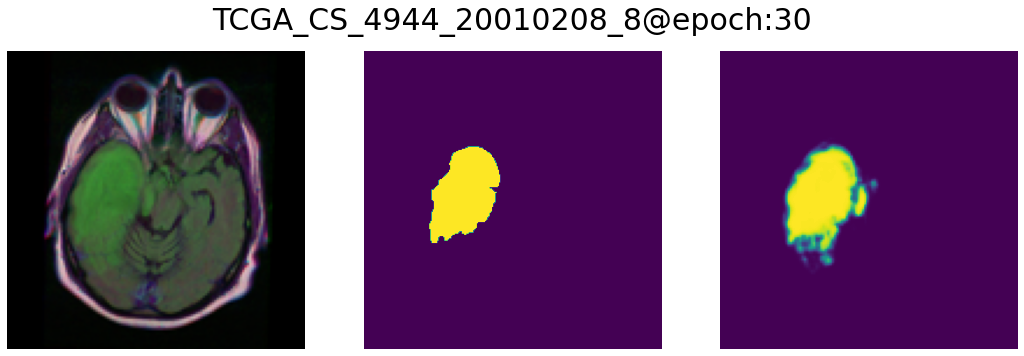

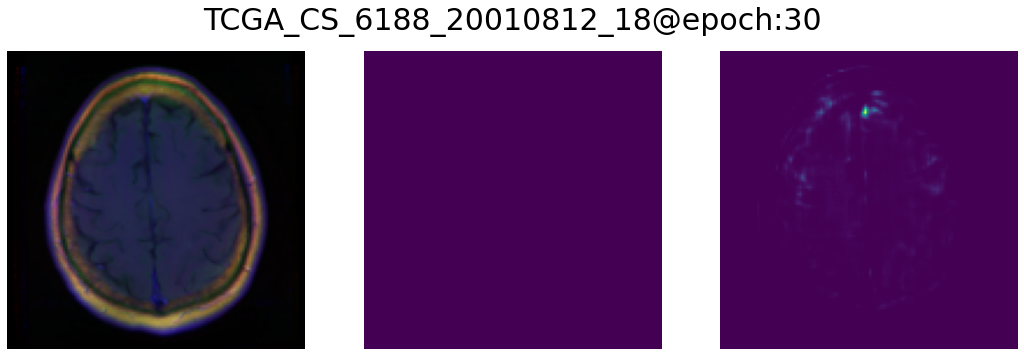

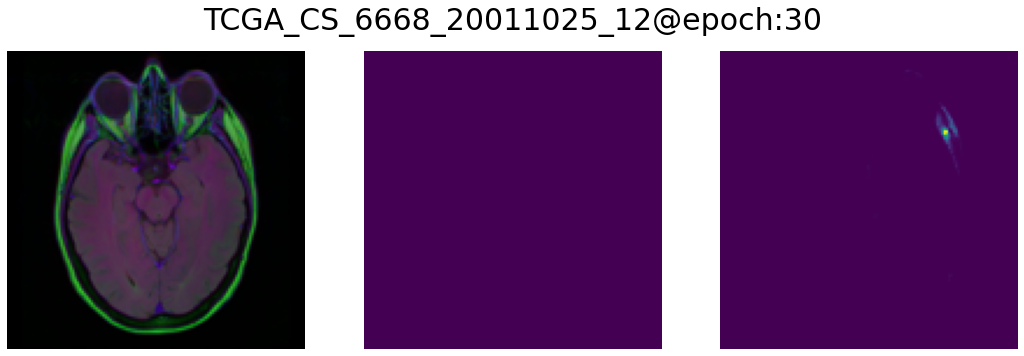

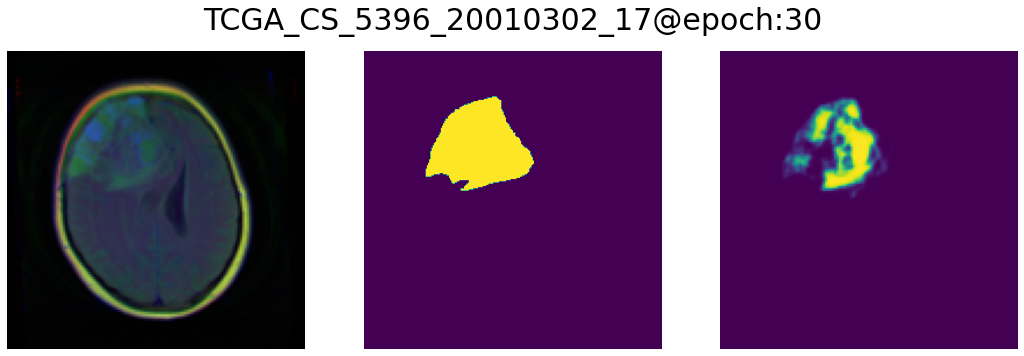

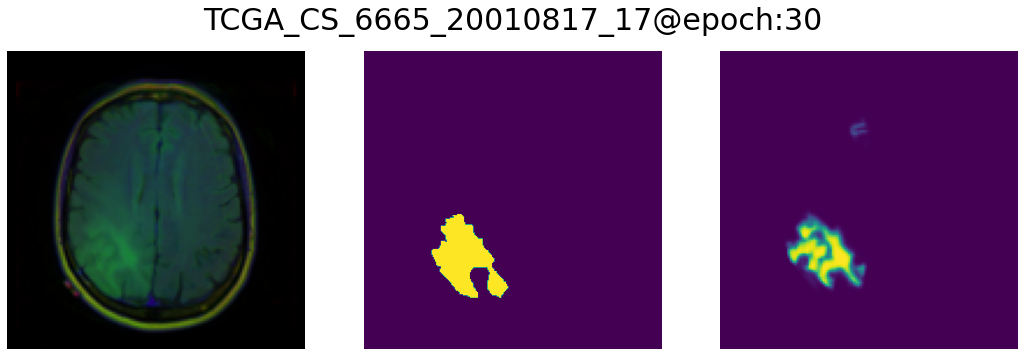

In [6]:
unet = UNet(3).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr = lr)
criterion = F.binary_cross_entropy
list_sample_result = []

for epoch in range(num_epoch):
    unet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_first = True
    for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
        list_plots.append(show_result_unet(unet, img_torch, img_raw, mask, f'{fname}@epoch:{epoch}', show_result = show_first))
        show_first = False
    list_sample_result.append(list_plots)
    
    for image, mask, _ in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        # Forward
        pred = unet(image)
        # Get Loss
        loss = criterion(pred, mask)
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
    list_plots.append(show_result_unet(unet, img_torch, img_raw, mask, f'{fname}@epoch:{epoch + 1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/mri@unet-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

<img src="./images/mri@unet-TCGA_CS_4944_20010208_8.gif" width="750" align="center">

# Train BESNet without BECE Loss

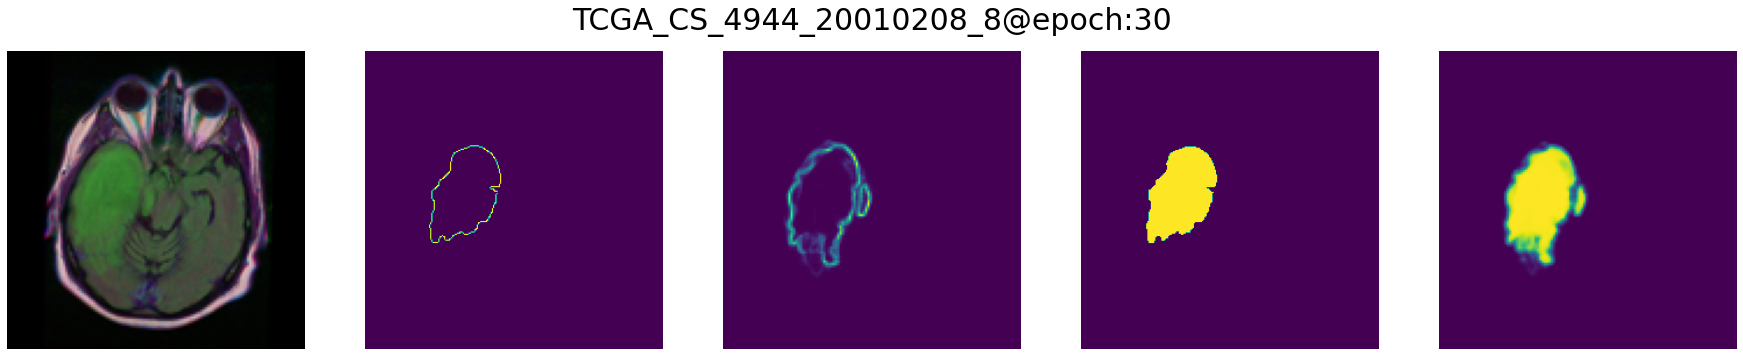

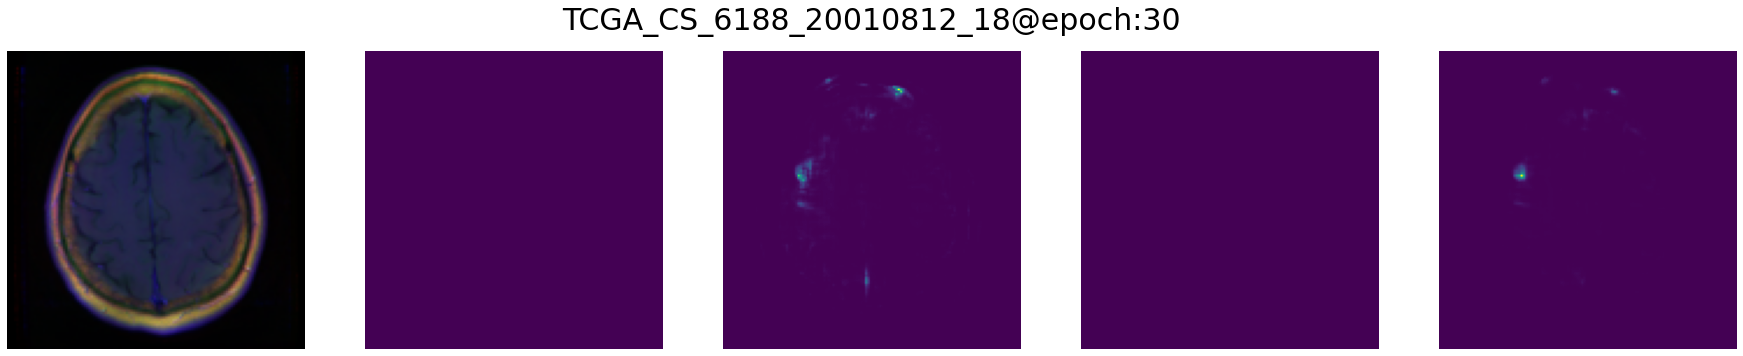

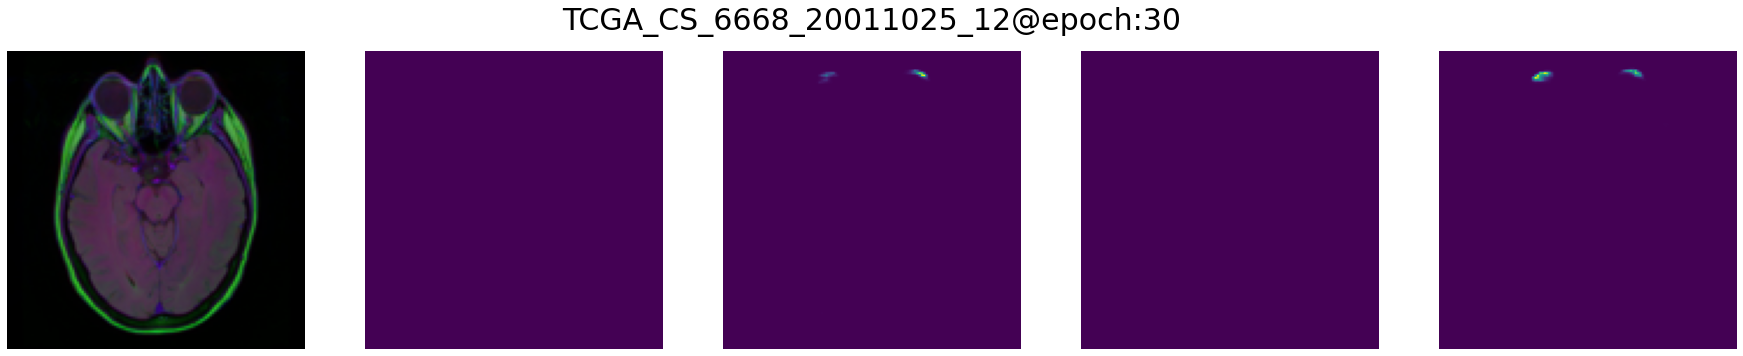

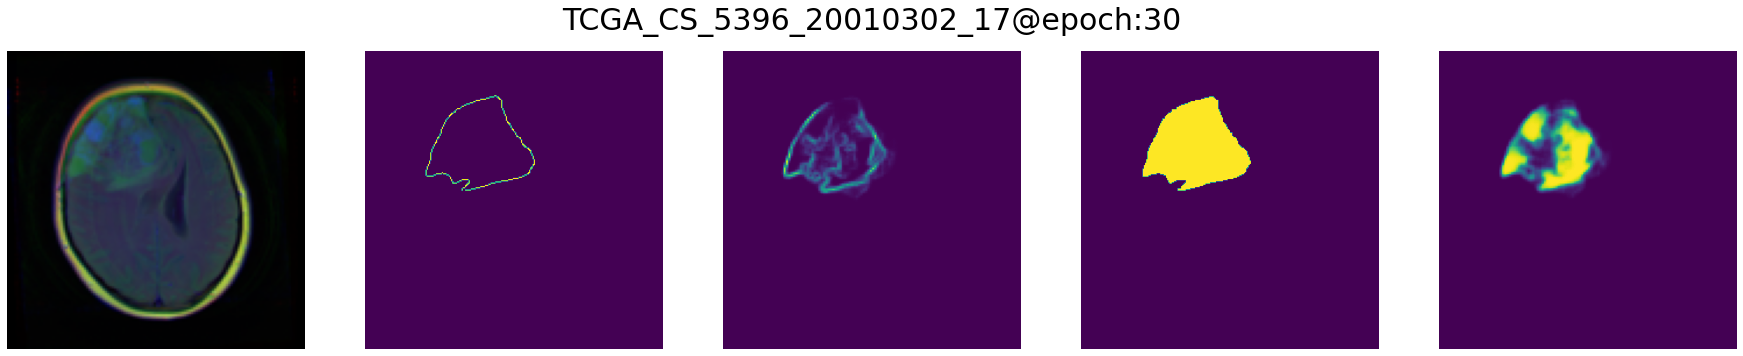

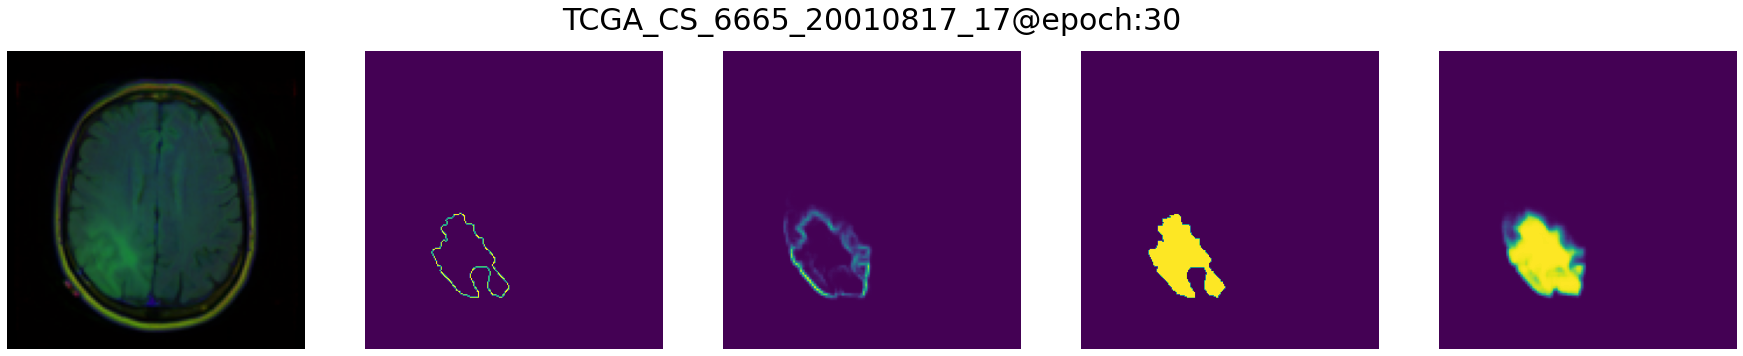

In [7]:
besnet = BESNet(3).to(device)
optimizer = torch.optim.Adam(besnet.parameters(), lr = lr)
criterion_bdp = F.binary_cross_entropy
criterion_mdp = F.binary_cross_entropy
list_sample_result = []

for epoch in range(num_epoch):
    besnet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_first = True
    for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
        list_plots.append(show_result_besnet(besnet, img_torch, img_raw, mask, edge, f'{fname}@epoch:{epoch}', show_result = show_first))
        show_first = False
    list_sample_result.append(list_plots)
    
    for image, mask, edge in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        edge = edge.to(device)
        # Forward
        bdp, mdp = besnet(image)
        # Get Loss
        bdp_loss = criterion_bdp(bdp, edge)
        mdp_loss = criterion_mdp(mdp, mask)
        loss = bdp_loss + mdp_loss
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'bdp_error': np.round(bdp_loss.item(), 2), 'mdp_error': np.round(mdp_loss.item(), 2), 'total_error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
    list_plots.append(show_result_besnet(besnet, img_torch, img_raw, mask, edge, f'{fname}@epoch:{epoch+1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/mri@besnet_without_bece-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

<img src="./images/mri@besnet_without_bece-TCGA_CS_4944_20010208_8.gif" width="750" align="center">

# Train BESNet with BECE Loss

In [8]:
def mdp_bece_loss(output, target, bdp):
    bx = alpha * torch.max(beta - bdp, torch.zeros_like(bdp))
    loss = target * torch.log(output + torch.finfo(torch.float32).eps)
    loss += (1 - target) * torch.log(1 - output + torch.finfo(torch.float32).eps)
    return -loss.mean()

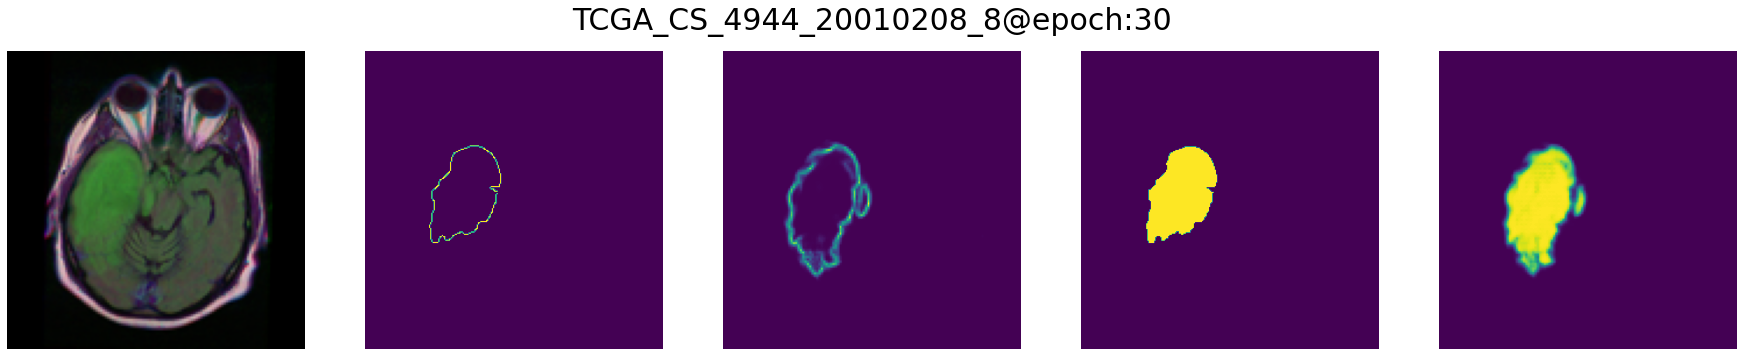

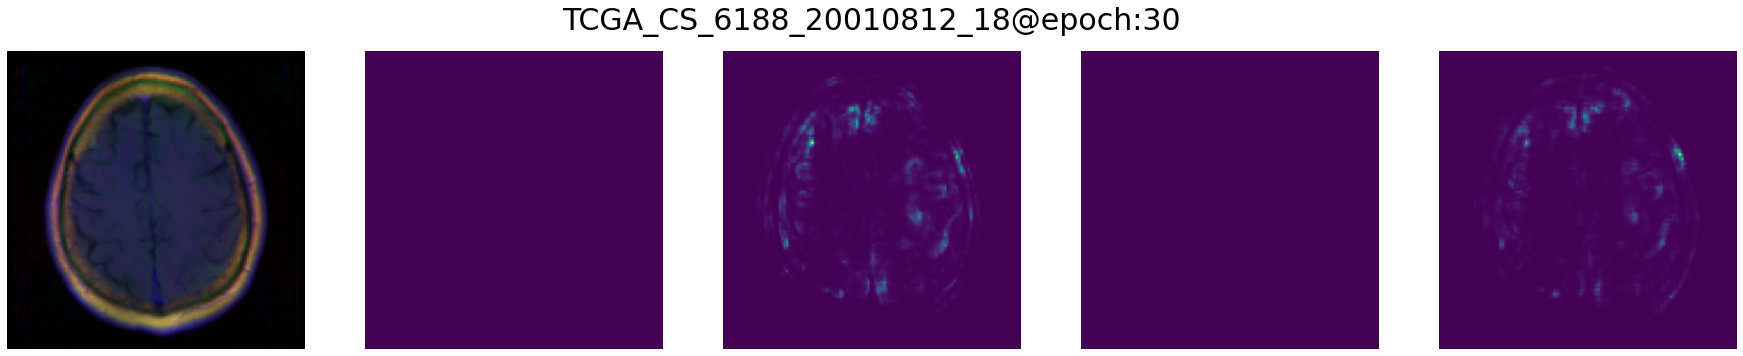

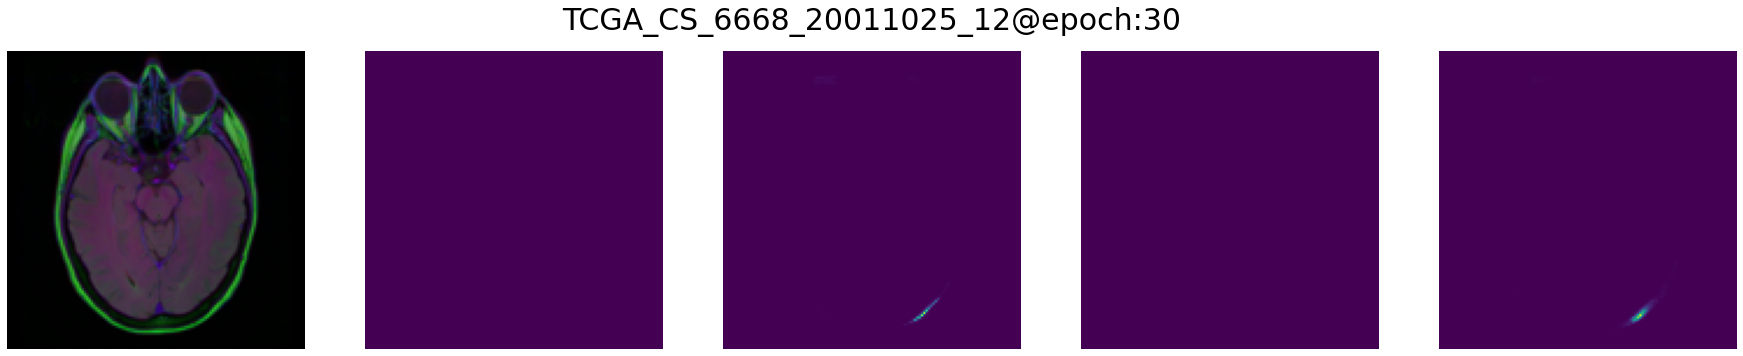

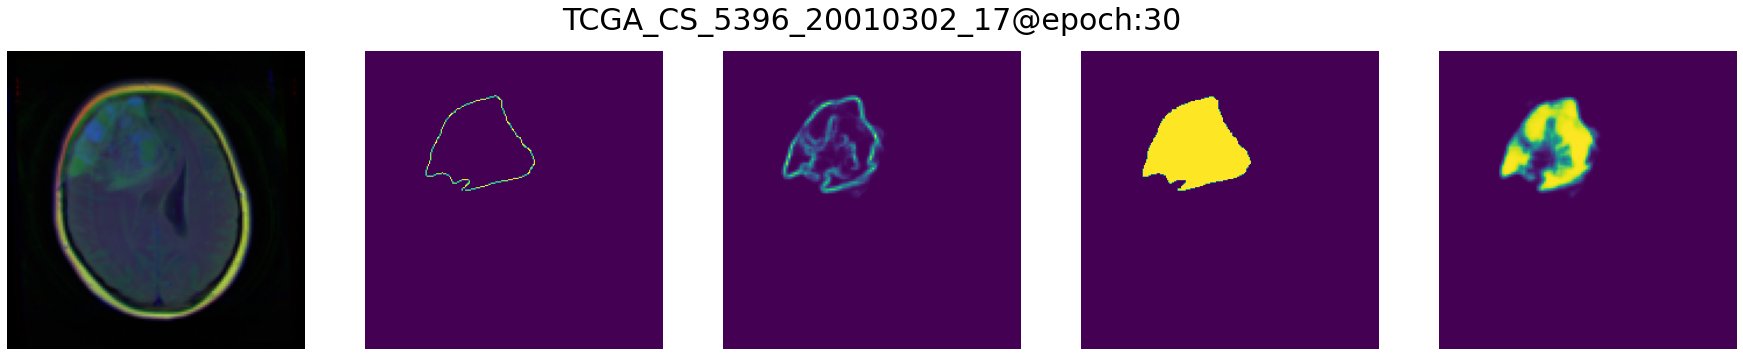

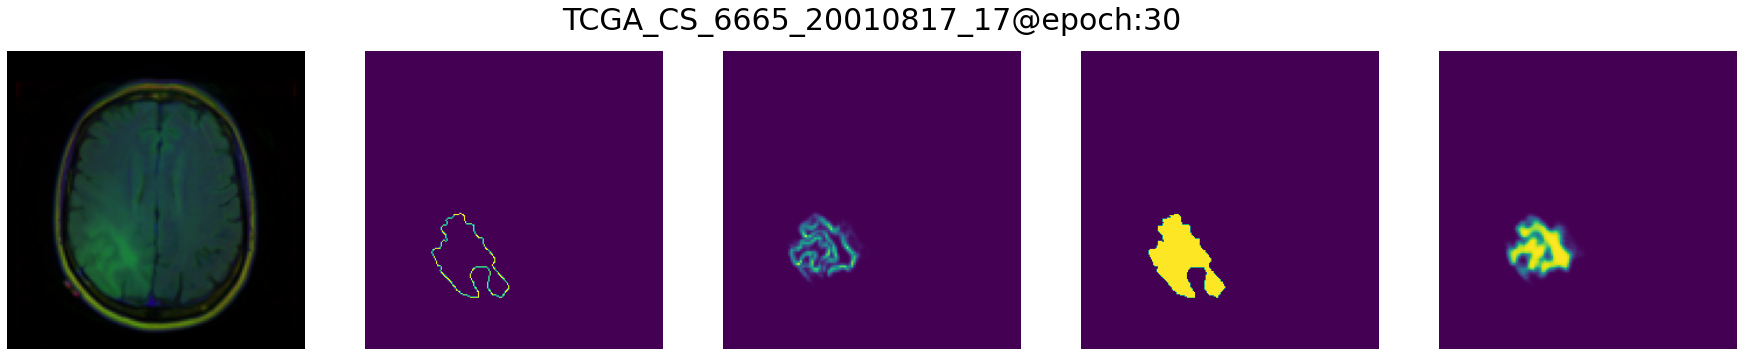

In [9]:
besnet = BESNet(3).to(device)
optimizer = torch.optim.Adam(besnet.parameters(), lr = lr)
criterion_bdp = F.binary_cross_entropy
criterion_mdp = mdp_bece_loss
list_sample_result = []

for epoch in range(num_epoch):
    besnet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_shiba = True
    for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
        list_plots.append(show_result_besnet(besnet, img_torch, img_raw, mask, edge, f'{fname}@epoch:{epoch}', show_result = show_shiba))
        show_shiba = False
    list_sample_result.append(list_plots)
    
    for image, mask, edge in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        edge = edge.to(device)
        # Forward
        bdp, mdp = besnet(image)
        # Get Loss
        bdp_loss = criterion_bdp(bdp, edge)
        mdp_loss = criterion_mdp(mdp, mask, bdp)
        loss = bdp_loss + mdp_loss
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'bdp_error': np.round(bdp_loss.item(), 2), 'mdp_error': np.round(mdp_loss.item(), 2), 'total_error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, mask, edge, fname in zip(list_images, list_images_reshaped, list_mask, list_edge, sample_image_files):
    list_plots.append(show_result_besnet(besnet, img_torch, img_raw, mask, edge, f'{fname}@epoch:{epoch+1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/mri@besnet_with_bece-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

<img src="./images/mri@besnet_with_bece-TCGA_CS_4944_20010208_8.gif" width="750" align="center">